### Importando bibliotecas

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay,f1_score,confusion_matrix,recall_score,precision_score,accuracy_score

### 1. Carregando os dados

In [2]:
import os
import pandas as pd

caminho = 'C:\\Users\\lucas\\Downloads\\superficie_seletiva_de_frequencia\\chest_xray\\chest_xray'

labels = ['train', 'test']
data = []

for folder in labels:
    folder_path = os.path.join(caminho, folder)
    for label in ['NORMAL', 'PNEUMONIA']:
        label_folder = os.path.join(folder_path, label)
        if os.path.exists(label_folder):  # Verifica se a pasta existe
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.jpeg') or file_name.endswith('.png') or file_name.endswith('.jpg'):
                    file_path = os.path.join(label_folder, file_name)
                    data.append([file_path, label.lower()])

df = pd.DataFrame(data, columns=['file_path', 'label'])


### 1.1 Transformando as saídas em 0 e 1

In [3]:
# transformando as labels em 0 e 1
df['label'].unique()
df['label']=df['label'].map({'normal':0,'pneumonia':1})

In [4]:
df['label'].dtype

dtype('int64')

### 1.2 Exibindo as 25 primeiras imagens

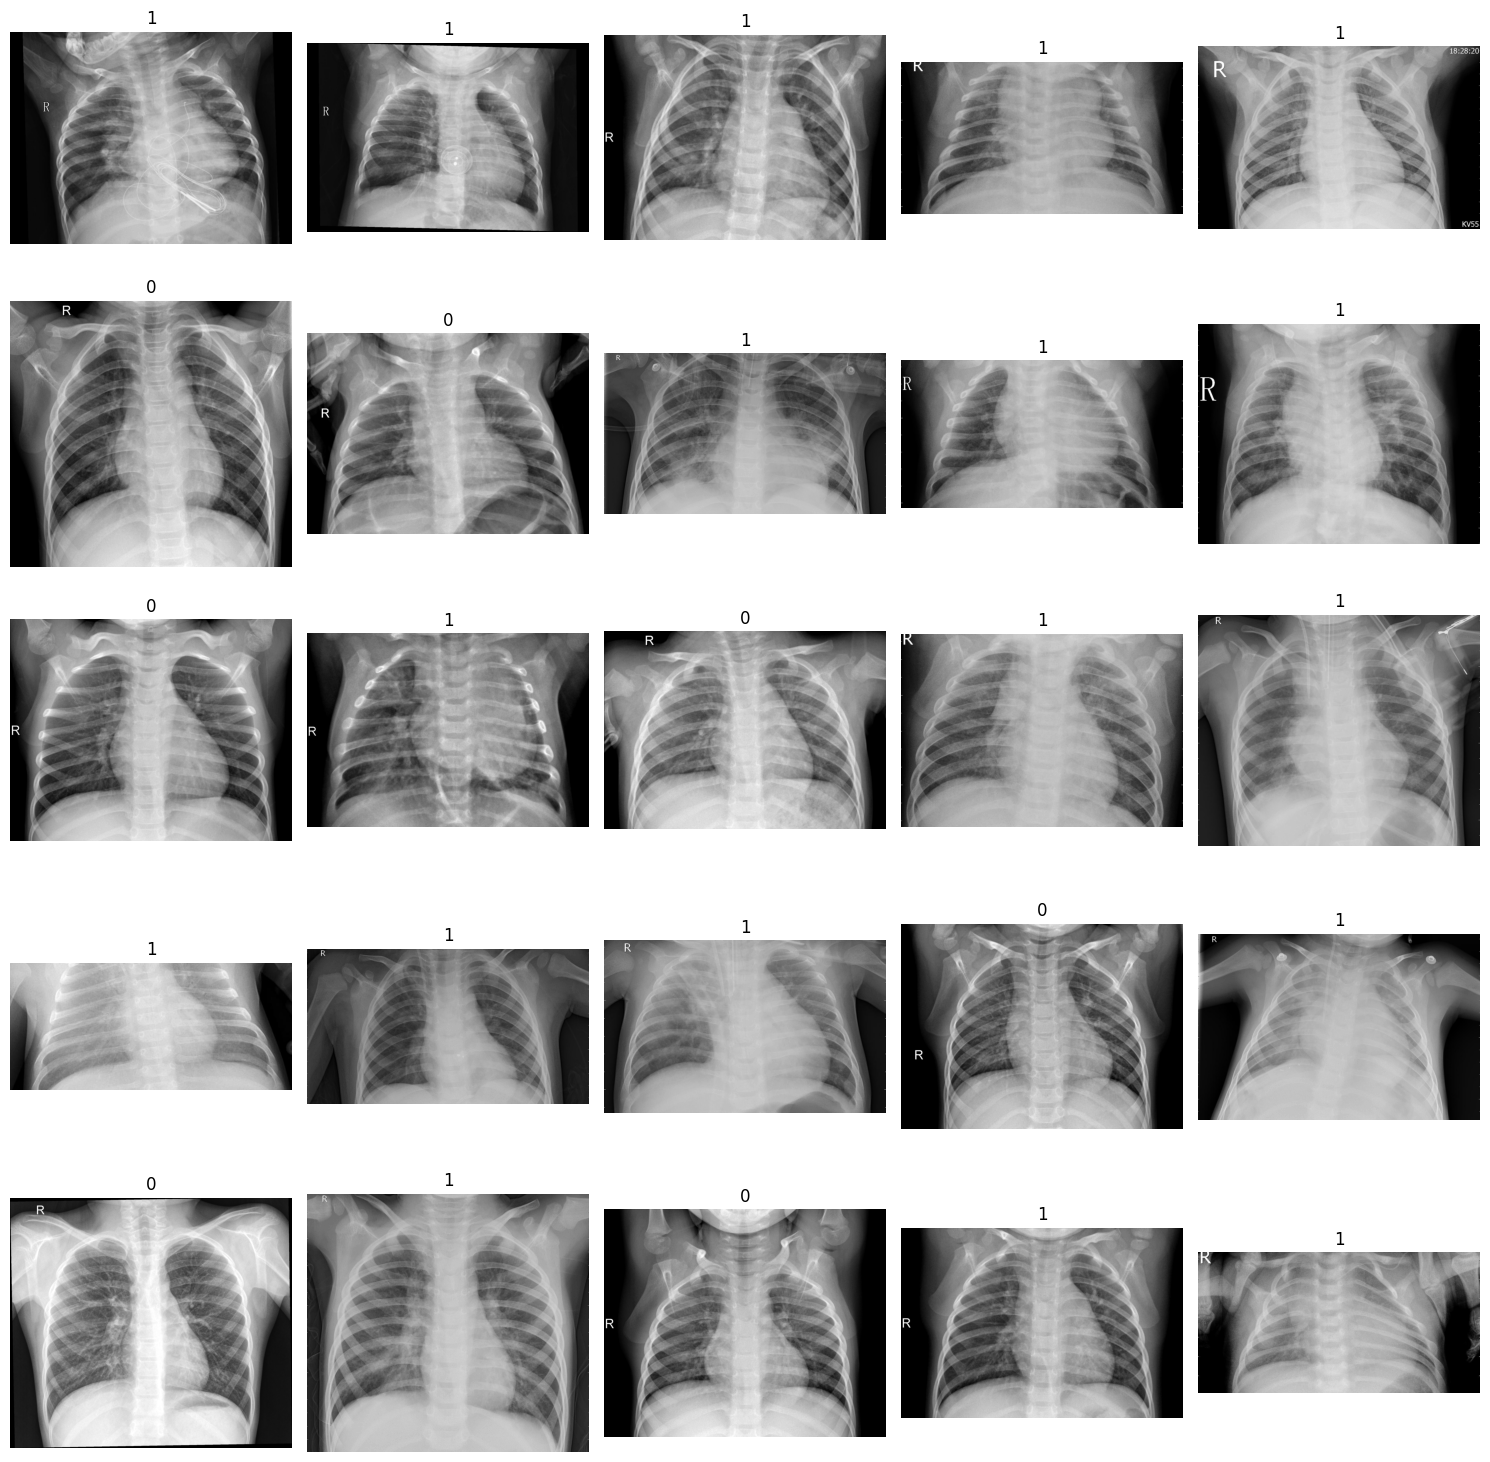

In [5]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(25):
    ax = axes.flatten()[i]
    row = df.sample(1).iloc[0]
    img = cv2.imread(row['file_path'])
    img_norm = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_normalized = img_norm / 255.0
    
    ax.imshow(img_gray_normalized, cmap='gray')
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()


### 1.3 Exibindo as informações dos dados

In [6]:
df.shape

(5840, 2)

In [7]:
df.head(10)

,file_path,label
0,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
1,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
2,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
3,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
4,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
5,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
6,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
7,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
8,C:\Users\lucas\Downloads\superficie_seletiva_d...,0
9,C:\Users\lucas\Downloads\superficie_seletiva_d...,0


In [8]:
df.tail(10)

,file_path,label
5830,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5831,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5832,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5833,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5834,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5835,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5836,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5837,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5838,C:\Users\lucas\Downloads\superficie_seletiva_d...,1
5839,C:\Users\lucas\Downloads\superficie_seletiva_d...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  5840 non-null   object
 1   label      5840 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.4+ KB


In [10]:
# Verificando as dimensões da imagem
img = cv2.imread(df.iloc[0]['file_path'])

altura, largura, d = img.shape
print(img.shape)
print(f"Dimensão da imagem: {largura}x{altura}")

(1858, 2090, 3)
Dimensão da imagem: 2090x1858


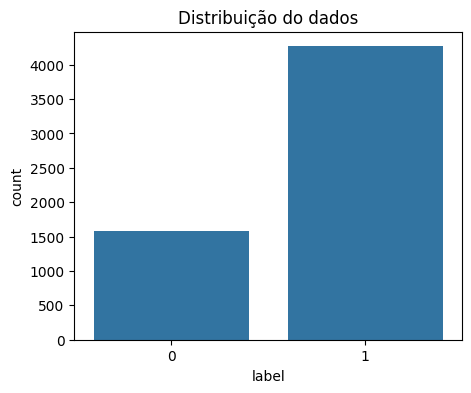

In [11]:
# exibindo a quantidade de registros
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='label')
plt.title('Distribuição do dados')
plt.show()

### 2.0 Normalizando os dados

In [107]:
norm_img = []

for img_path in df['file_path']:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Carrega como escala de cinza
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    norm_img.append(img[..., np.newaxis])  # Adiciona uma nova dimensão para o canal

X = np.array(norm_img, dtype='float32')
y = df['label'].values


In [109]:
len(norm_img) # quantidade de dados normalizados

5840

### 2.1 Dados de teste e treino

In [110]:
X = np.array(norm_img)
y = df['label']

### 2.2 Separação dos dados

In [112]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Analisando as dimensões de treino e de teste

In [113]:
x_train.shape, y_train.shape

((4672, 128, 128, 1), (4672,))

In [114]:
x_test.shape, y_test.shape

((1168, 128, 128, 1), (1168,))

### 3.0 Modelo da rede CNN

In [115]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding ="same", input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(64, (3, 3), activation='relu', padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu',  padding ="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  

model.summary()

c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,059,969 (4.04 MB)

 Trainable params: 1,059,969 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.02)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
# aplicando o critério de parada e patience de 5
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [118]:
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 640ms/step - accuracy: 0.7392 - loss: 0.6512 - val_accuracy: 0.7390 - val_loss: 0.5907
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 529ms/step - accuracy: 0.7336 - loss: 0.5036 - val_accuracy: 0.9070 - val_loss: 0.2530
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 535ms/step - accuracy: 0.9061 - loss: 0.2470 - val_accuracy: 0.9380 - val_loss: 0.1809
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 547ms/step - accuracy: 0.9318 - loss: 0.1785 - val_accuracy: 0.9187 - val_loss: 0.2124
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 528ms/step - accuracy: 0.9281 - loss: 0.1774 - val_accuracy: 0.9219 - val_loss: 0.2061
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 536ms/step - accuracy: 0.9439 - loss: 0.1341 - val_accuracy: 0.9348 - val_loss: 0.1611
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 633ms/step - accuracy: 0.9482 - loss: 0.1343 - val_accuracy: 0.9412 - val_loss: 0.1478
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 569ms/step - accuracy: 0.9539 - loss: 0.1258 - val_accu

In [133]:
# salvar o loss
pd.DataFrame(history.history).to_csv('loss.csv', index=False)


In [134]:
# salvar o modelo
model.save('model.keras')

### 3.1 Visualizando o erro e a acurácia

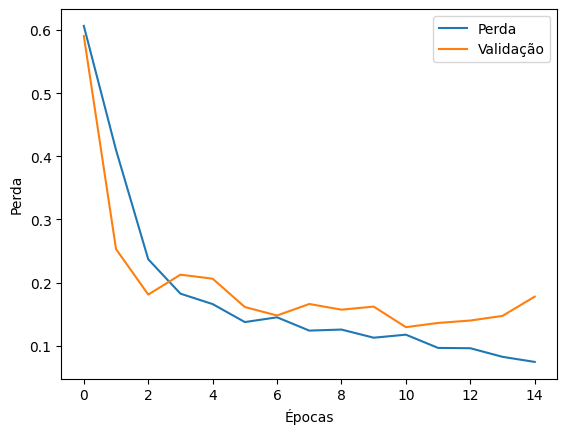

In [121]:
plt.plot(history.history['loss'], label='Perda')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

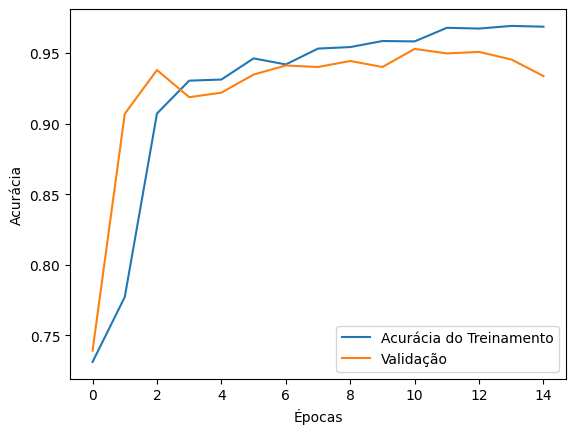

In [122]:
plt.plot(history.history['accuracy'], label='Acurácia do Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [123]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Acurácia do modelo: {acc * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9556 - loss: 0.1387
Acurácia do modelo: 95.12%


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


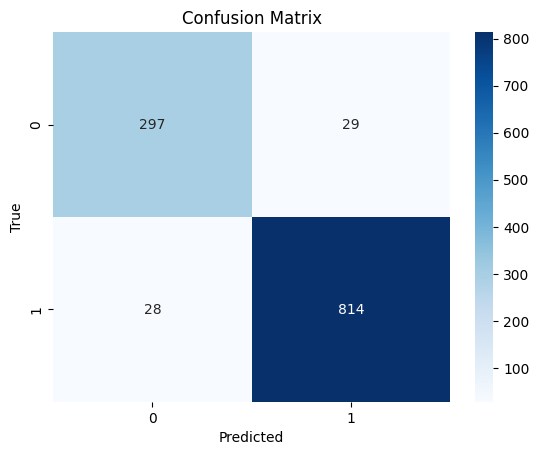

In [124]:
# Previsão das classes com base no limiar de 0.5
predict=model.predict(x_test)
predicted_classes = (predict > 0.5).astype(int)

# Gera a matriz de confusão
conf_matrix = confusion_matrix(y_test, predicted_classes)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [132]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Converter probabilidades para rótulos binários (se `predict` for contínuo)
predict_binary = np.where(predict >= 0.5, 1, 0)  # Para classificação binária

# Calcular acurácia
accuracy = accuracy_score(y_test, predict_binary)
print("Acurácia:", accuracy * 100, "%")

# Calcular precisão
precision = precision_score(y_test, predict_binary, average='macro')
print("Precisão:", precision * 100, "%")

# Calcular recall
recall = recall_score(y_test, predict_binary, average='macro')
print("Recall:", recall * 100, "%")

# Calcular F1 score
f1 = f1_score(y_test, predict_binary, average='macro')
print("F1-score:", f1 * 100, "%")


Acurácia: 95.11986301369863 %
Precisão: 93.97226024272287 %
Recall: 93.88943940078398 %
F1-score: 93.93072515691449 %


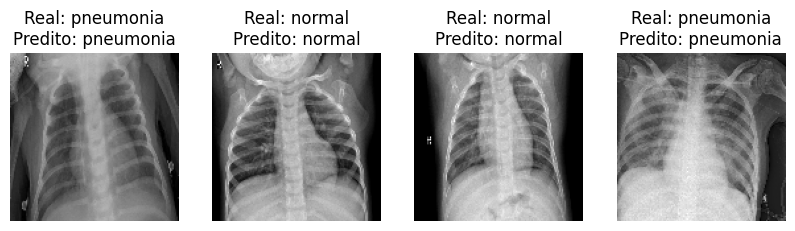

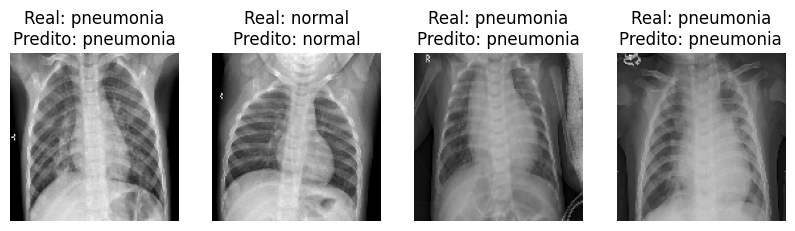

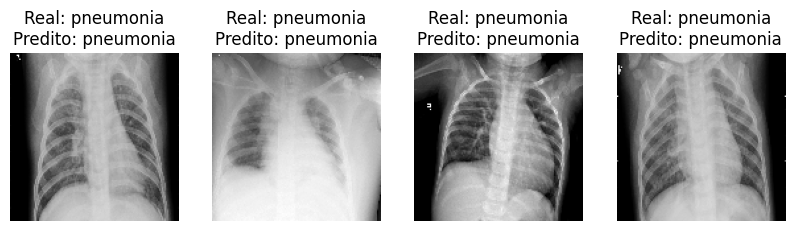

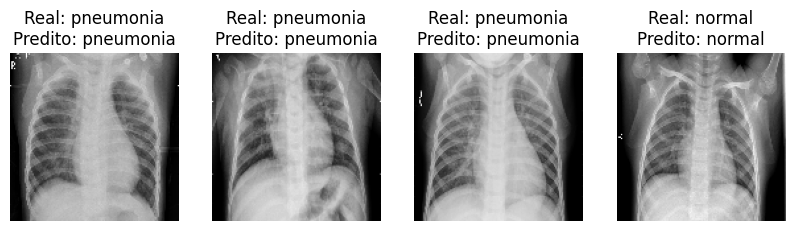

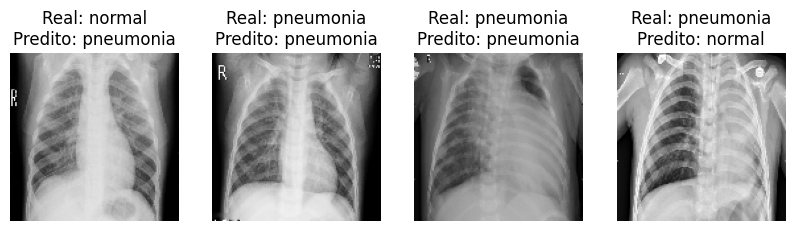

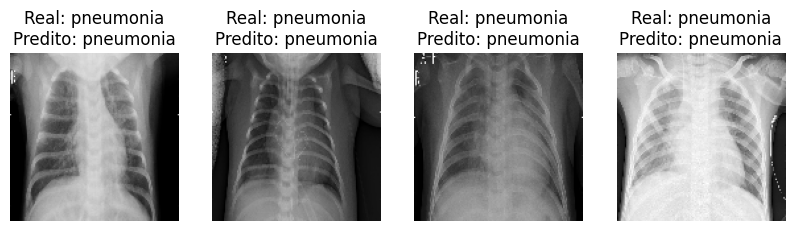

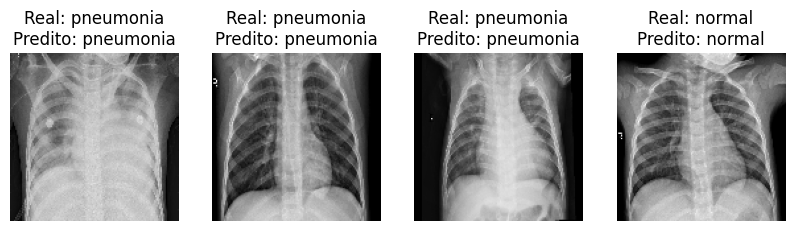

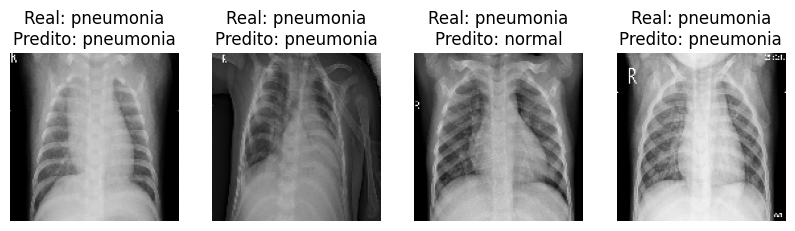

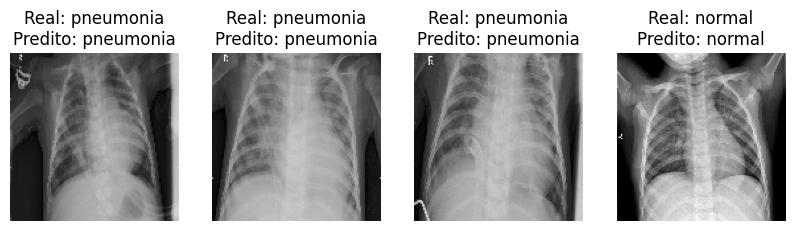

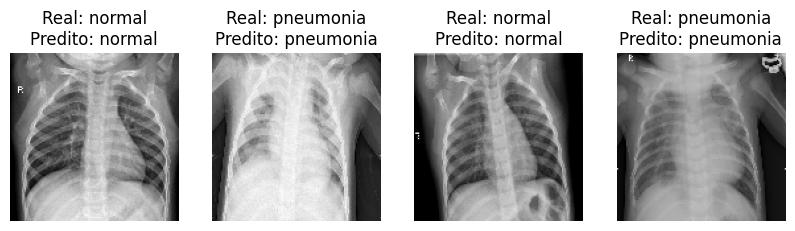

In [129]:
import matplotlib.pyplot as plt

n = 4
classes = ['normal', 'pneumonia'] 
preds = (predict > 0.5).astype(int)  # Converte as previsões em 0 ou 1 

for t in range(10):
    plt.figure(figsize=(10, 10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(x_test[i], cmap='gray')  # Exibe as imagens no formato correto
        real_label = int(y_test[i]) if isinstance(y_test, np.ndarray) else int(y_test.iloc[i])
        predicted_label = int(preds[i][0])  # Certifique-se de que a predição é binária
        plt.title('Real: {}\nPredito: {}'.format(classes[real_label], classes[predicted_label]))
        plt.axis('off')
    plt.show()
